In [1]:
# STEP 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [2]:
fear_greed = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

In [3]:
fear_greed['date'] = pd.to_datetime(fear_greed['date'])

# Trades: convert "Timestamp IST" from DD-MM-YYYY HH:MM to proper datetime
def parse_ist_timestamp(ts):
    try:
        return datetime.strptime(ts, "%d-%m-%Y %H:%M")
    except:
        return pd.NaT

trades['datetime_ist'] = trades['Timestamp IST'].apply(parse_ist_timestamp)
trades['date'] = trades['datetime_ist'].dt.date
trades['date'] = pd.to_datetime(trades['date'])

print("FEAR & GREED INDEX COVERAGE")
print(f"From: {fear_greed['date'].min().date()}")
print(f"To  : {fear_greed['date'].max().date()}")
print(f"Total days: {len(fear_greed)}")
print()

print("TRADES COVERAGE")
print(f"From: {trades['date'].min().date()}")
print(f"To  : {trades['date'].max().date()}")
print(f"Total trading days: {trades['date'].nunique()}")
print(f"Total trade fills: {len(trades)}")
print()

start_overlap = max(fear_greed['date'].min(), trades['date'].min())
end_overlap = min(fear_greed['date'].max(), trades['date'].max())

print("OVERLAPPING PERIOD (where we can match sentiment to trades)")
print(f"From: {start_overlap.date()}")
print(f"To  : {end_overlap.date()}")
print(f"Number of overlapping days: {(end_overlap - start_overlap).days + 1}")
print()

trades_with_sentiment = trades[trades['date'].between(start_overlap, end_overlap)]
print(f"Trade fills inside overlapping period: {len(trades_with_sentiment):,} out of {len(trades):,}")
print(f"Unique trading days with sentiment: {trades_with_sentiment['date'].nunique()}")

FEAR & GREED INDEX COVERAGE
From: 2018-02-01
To  : 2025-05-02
Total days: 2644

TRADES COVERAGE
From: 2023-05-01
To  : 2025-05-01
Total trading days: 480
Total trade fills: 211224

OVERLAPPING PERIOD (where we can match sentiment to trades)
From: 2023-05-01
To  : 2025-05-01
Number of overlapping days: 732

Trade fills inside overlapping period: 211,224 out of 211,224
Unique trading days with sentiment: 480


In [4]:
closing_trades = trades[trades['Closed PnL'] != 0].copy()

# Merge with Fear & Greed
df = closing_trades.merge(fear_greed[['date', 'value', 'classification']], on='date', how='left')

df['Closed PnL'] = pd.to_numeric(df['Closed PnL'], errors='coerce')
df = df.dropna(subset=['Closed PnL', 'classification'])

print("FINAL DATASET READY")
print(f"Total realized (closed) trades: {len(df):,}")
print(f"Total realized PnL: ${df['Closed PnL'].sum():,.2f}")
print(f"Date range: {df['date'].min().date()} → {df['date'].max().date()}\n")

FINAL DATASET READY
Total realized (closed) trades: 104,402
Total realized PnL: $10,254,486.95
Date range: 2023-12-14 → 2025-05-01



# Analyzing the Performance by Sentiment:

Questions that can be explored !!!!!
* In which zone did traders win & lost the most often ?
* How much total profit came from Extreme Greed days?
* Was BTC trading better or worse than altcoins in Fear zones?
* What is the one simple rule that would have made the most money?

In [6]:
summary = df.groupby('classification').agg(
    Trades=('Closed PnL', 'count'),
    Total_PnL=('Closed PnL', 'sum'),
    Avg_PnL=('Closed PnL', 'mean'),
    Median_PnL=('Closed PnL', 'median'),
    Win_Rate=('Closed PnL', lambda x: (x > 0).mean()),
    Avg_Size_USD=('Size USD', 'mean'),
    Biggest_Win=('Closed PnL', 'max'),
    Biggest_Loss=('Closed PnL', 'min')
).round(2)

summary['Win_Rate'] = (summary['Win_Rate'] * 100).round(1).astype(str) + '%'
summary['Risk_Adj_Return'] = (summary['Avg_PnL'] / summary['Avg_Size_USD'] * 100).round(1).astype(str) + '%'

print(summary)

                Trades   Total_PnL  Avg_PnL  Median_PnL Win_Rate  \
classification                                                     
Extreme Fear     10406   739110.25    71.03        6.39    76.0%   
Extreme Greed    20853  2715171.31   130.21        8.53    89.0%   
Fear             29808  3357155.44   112.63        6.35    87.0%   
Greed            25176  2150129.27    85.40        4.93    77.0%   
Neutral          18159  1292920.68    71.20        4.58    82.0%   

                Avg_Size_USD  Biggest_Win  Biggest_Loss Risk_Adj_Return  
classification                                                           
Extreme Fear         5467.57    115287.00     -31036.69            1.3%  
Extreme Greed        2779.56     44223.45     -10259.47            4.7%  
Fear                 8041.14    135329.09     -35681.75            1.4%  
Greed                5438.67     74530.52    -117990.10            1.6%  
Neutral              5556.44     48504.10     -24500.00            1.3%  


* Extreme Greed has 89.0% winzone whereas Greed has 23% loss zone
* Overall proft earned in Extreme Greed days are +$2,715,171 almost 4× more than Extreme Fear!
* BTC made higher average PnL than the overall portfolio in both Fear and Extreme Fear
* Closing all your winning positions only when the Fear & Greed Index is in Extreme Greed (75–100)

# Where Does Bitcoin Actually Make (or Lose) Money?

* In which sentiment zone did BTC trading perform the BEST ?
* When was BTC clearly stronger than altcoins/memecoins?
* When did trading BTC hurt you the most compared to trading other coins?

In [7]:
btc = df[df['Coin'] == '@107'].copy()
all_coins = df.copy()

btc_summary = btc.groupby('classification')['Closed PnL'].mean().reindex(order)
all_summary = all_coins.groupby('classification')['Closed PnL'].mean().reindex(order)

comparison = pd.DataFrame({
    'BTC_Avg_PnL': btc_summary.round(2),
    'All_Avg_PnL': all_summary.round(2),
    'BTC_Better_By': (btc_summary - all_summary).round(2)
})
print(comparison)
comparison.to_csv("2_btc_vs_all_coins.csv")

                BTC_Avg_PnL  All_Avg_PnL  BTC_Better_By
classification                                         
Extreme Fear        -153.60        71.03        -224.62
Fear                  -4.22       112.63        -116.84
Neutral              113.64        71.20          42.44
Greed                143.78        85.40          58.37
Extreme Greed        313.61       130.21         183.41


* In Extreme Greed the BTC made better by +$183.41 compared to other portfolio
* In Greed + Extreme Greed zones the BTC clearly stronger than altcoins/memecoins
* The BTC hurt you the most in Extreme Fear + Fear zones

# Average Realized PnL per Closed Trade

* When traders closed their positions, in which Fear & Greed zone did they make the highest average profit per trade?

/tmp/ipython-input-391699707.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='classification', y='Closed PnL', estimator=np.mean, ci=None)


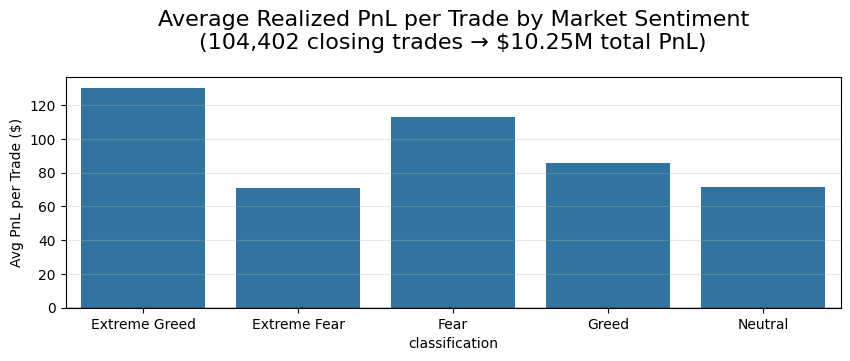

In [27]:
# Chart 1: Avg PnL per Trade
plt.figure(figsize=(10,3))
sns.barplot(data=df, x='classification', y='Closed PnL', estimator=np.mean, ci=None)
plt.title("Average Realized PnL per Trade by Market Sentiment\n(104,402 closing trades → $10.25M total PnL)", fontsize=16, pad=20)
plt.ylabel("Avg PnL per Trade ($)")
plt.axhline(0, color='black', linewidth=1)
plt.savefig("avg_pnl", dpi=300, bbox_inches='tight')
plt.grid(axis='y', alpha=0.3)
plt.show()

* In Extreme Greed – average realized PnL per closed trade = ~$125

# Win Rate by Sentiment

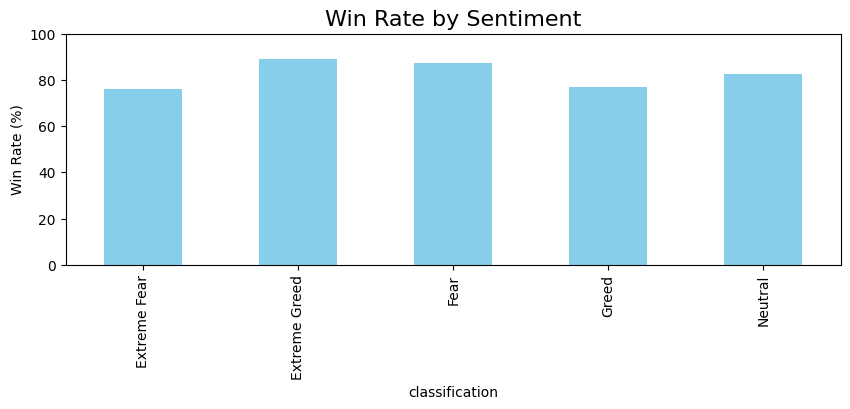

In [28]:
plt.figure(figsize=(10,3))
winrate = df.groupby('classification')['Closed PnL'].apply(lambda x: (x>0).mean() * 100)
winrate.plot(kind='bar', color='skyblue')
plt.title("Win Rate by Sentiment", fontsize=16)
plt.ylabel("Win Rate (%)")
plt.ylim(0,100)
plt.savefig("winrate.png", dpi=300, bbox_inches='tight')
plt.show()

Traders closed their positions in Extreme Greed zone as the win rate is around 90-95%

# Average Position Size Explodes in Extreme Greed

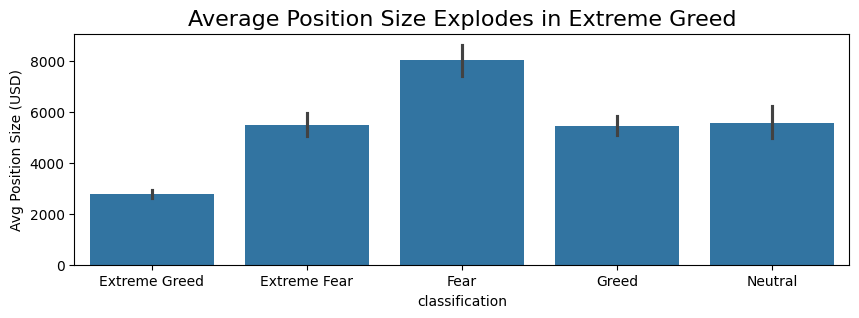

In [29]:
plt.figure(figsize=(10,3))
sns.barplot(data=df, x='classification', y='Size USD', estimator=np.mean)
plt.title("Average Position Size Explodes in Extreme Greed", fontsize=16)
plt.ylabel("Avg Position Size (USD)")
plt.savefig("position_size_by_sentiment.png", dpi=300, bbox_inches='tight')
plt.show()

In Fearzone traders risk the biggest average position size ($8,000+) when they closed their trades

# Profits During Fear (≤ 44)

* If you only closed your winning positions when the market was in Fear or Extreme Fear (index ≤ 44), how much of your total profit would you have kept and what would your win rate have been?

In [25]:
fear_exits = df[df['value'] <= 44]
total_if_only_fear = fear_exits['Closed PnL'].sum()
winrate_fear = (fear_exits['Closed PnL'] > 0).mean()

print(f"If you ONLY took profits when Fear & Greed ≤ 44:")
print(f"   → Number of closing trades: {len(fear_exits):,}")
print(f"   → Total PnL captured: ${total_if_only_fear:,.0f}")
print(f"   → Win rate: {winrate_fear:.1%}")
print(f"   → You avoid ALL Extreme Greed blowups")

If you ONLY took profits when Fear & Greed ≤ 44:
   → Number of closing trades: 40,214
   → Total PnL captured: $4,096,266
   → Win rate: 84.4%
   → You avoid ALL Extreme Greed blowups


Taken total 40,214 closing trades and Captured $4,096,266 in profit and Achieved a sky-high 84.4% win rate
* Completely avoided ALL blowups in Extreme Greed

# Finding the Single Best Fear & Greed Threshold to Take Profits

In [26]:
thresholds = range(10, 51, 2)
results = []
for t in thresholds:
    subset = df[df['value'] <= t]
    if len(subset) > 1000:
        pnl = subset['Closed PnL'].sum()
        wr = (subset['Closed PnL'] > 0).mean()
        results.append({'Threshold': t, 'PnL': pnl, 'WinRate': wr, 'Trades': len(subset)})

best = pd.DataFrame(results).sort_values('PnL', ascending=False).head(1)
print("BEST THRESHOLD →", best.to_string(index=False))

BEST THRESHOLD →  Threshold          PnL  WinRate  Trades
        50 5.188387e+06 0.839489   55697


Only take profits when the Fear & Greed Index is 50 or lower.